In [8]:
import random
from typing import List, Tuple, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ActionSpace:

    def __init__(self, actions: List[str]):
        self._actions = actions

    def sample(self):
        return random.choice(range(len(self._actions)))

    @property
    def actions(self) -> List[str]:
        return self._actions

In [3]:
class MarketEnv:
    """datetimeインデックス↔状態が1対1のみ許容"""

    def __init__(
        self,
        action_space: ActionSpace,
        df_states_ts: pd.DataFrame,
        df_rewards_ts: pd.DataFrame,
        state_seq_len: int = 1,
        start_dt: pd.Timestamp = None,
        end_dt: pd.Timestamp = None,
    ):
        self._action_space = action_space
        self._episode = 0
        self._df_states = df_states_ts
        self._df_rewards = df_rewards_ts
        self._state_seq_len = state_seq_len
        assert all([action in df_rewards_ts.columns for action in action_space.actions])
        assert (df_states_ts.index == df_rewards_ts.index).all()
        assert not df_states_ts.index.duplicated().any()
        self._cur_idx = self._state_seq_len
        if start_dt is not None:
            self._start_dt_idx = df_states_ts.index[df_states_ts.index >= start_dt].min()
        else:
            self._start_dt_idx = None
        if end_dt is not None:
            self._end_dt_idx = df_states_ts.index[df_states_ts.index <= end_dt].max()
        else:
            self._end_dt_idx = None

    def reset(self):
        if self._start_dt_idx is None:
            self._cur_idx = self._state_seq_len
        else:
            self._cur_idx = self._dt_index2idx(self._start_dt_idx) + self._state_seq_len
        return self._df_states.iloc[self._cur_idx - self._state_seq_len:self._cur_idx]

    def step(self, action: int):
        info = None
        cur_state = self._df_states.iloc[self._cur_idx - self._state_seq_len:self._cur_idx]
        next_state = self._df_states.iloc[self._cur_idx - self._state_seq_len + 1:self._cur_idx + 1]
        reward = self._df_rewards.iloc[self._cur_idx-1][self._action_space.actions[action]]
        if self._end_dt_idx is None:
            is_done = self._cur_idx == len(self._df_states) - 1
        else:
            is_done = self._cur_idx == self._dt_index2idx(self._end_dt_idx)
        self._cur_idx += 1
        return next_state, reward, is_done, info

    def _index2dt_idx(self, idx: int) -> pd.Timestamp:
        return self._df_states.index[idx]

    def _dt_index2idx(self, dt_idx: pd.Timestamp) -> int:
        return self._df_states.index.get_loc(dt_idx)

In [41]:
class MarketEnvMultiState:
    """datetimeインデックス↔状態が1対多の場合もあり"""

    def __init__(
        self,
        action_space: ActionSpace,
        df_states_ts: pd.DataFrame,
        df_rewards_ts: pd.DataFrame,
        state_seq_len: int = 1,
        start_dt: pd.Timestamp = None,
        end_dt: pd.Timestamp = None,
    ):
        self._action_space = action_space
        self._episode = 0
        self._df_states = df_states_ts
        self._df_rewards = df_rewards_ts
        self._dt_idx_unq = df_states_ts.index.unique()
        self._state_seq_len = state_seq_len
        assert all([action in df_rewards_ts.columns for action in action_space.actions])
        assert (df_states_ts.index == df_rewards_ts.index).all()
        self._df_states_rewards = pd.concat([df_states_ts, df_rewards_ts], axis=1)
        self._states_cols = df_states_ts.columns.tolist()
        self._rewards_cols = df_rewards_ts.columns.tolist()
        self._cur_idx = self._state_seq_len
        if start_dt is not None:
            self._start_dt_idx = df_states_ts.index[df_states_ts.index >= start_dt].min()
        else:
            self._start_dt_idx = None
        if end_dt is not None:
            self._end_dt_idx = df_states_ts.index[df_states_ts.index <= end_dt].max()
        else:
            self._end_dt_idx = None

    def reset(self):
        if self._start_dt_idx is None:
            self._cur_idx = self._state_seq_len
        else:
            self._cur_idx = self._dt_index2idx(self._start_dt_idx) + self._state_seq_len
        dt_indices = self._dt_idx_unq[self._cur_idx - self._state_seq_len:self._cur_idx]
        df_states, df_rewards = self._sample_n_per_dt_idx(dt_indices, n=1)
        return df_states, df_rewards

    def step(self, action: int, df_cur_states: pd.DataFrame, df_cur_rewards: pd.DataFrame):
        info = None
        cur_state_dt_indices = self._dt_idx_unq[self._cur_idx - self._state_seq_len:self._cur_idx]
        next_state_dt_indices = self._dt_idx_unq[self._cur_idx - self._state_seq_len + 1:self._cur_idx + 1]
        df_next_states, df_next_rewards = self._sample_n_per_dt_idx(next_state_dt_indices, n=1)
        if self._state_seq_len > 1:
            df_next_states = pd.concat([df_cur_states.iloc[:-1], df_next_states.iloc[-1:]])
            df_next_rewards = pd.concat([df_next_rewards.iloc[:-1], df_next_rewards.iloc[-1:]])
        reward = df_cur_rewards.iloc[-1][self._action_space.actions[action]]
        info = {'df_next_rewards': df_next_rewards}
        if self._end_dt_idx is None:
            is_done = self._cur_idx == len(self._dt_idx_unq) - 1
        else:
            is_done = self._dt_idx_unq[self._cur_idx] >= self._end_dt_idx
        self._cur_idx += 1
        return df_next_states, reward, is_done, info

    def _index2dt_idx(self, idx: int) -> pd.Timestamp:
        return self._df_states.index[idx]

    def _dt_index2idx(self, dt_idx: pd.Timestamp) -> int:
        return self._dt_idx_unq.get_loc(dt_idx)

    def _sample_n_per_dt_idx(self, dt_indices, n: int = 1) -> Tuple[pd.DataFrame, pd.DataFrame]:
        min_dt = dt_indices.min()
        max_dt = dt_indices.max()
        df_state_reward_in_periods = self._df_states_rewards.loc[min_dt:max_dt]
        df_state_reward = df_state_reward_in_periods.groupby(level=0, group_keys=False).apply(lambda df: df.sample(n))
        return df_state_reward[self._states_cols], df_state_reward[self._rewards_cols]

In [4]:
ACTIONS = [
    'do_nothing',
    'buy',
    'sell',
]
N_ACTIONS = len(ACTIONS)

In [5]:
dt_index = pd.date_range(start='2021-01-01', end='2023-01-01', freq='6H')

In [6]:
dt_index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 06:00:00',
               '2021-01-01 12:00:00', '2021-01-01 18:00:00',
               '2021-01-02 00:00:00', '2021-01-02 06:00:00',
               '2021-01-02 12:00:00', '2021-01-02 18:00:00',
               '2021-01-03 00:00:00', '2021-01-03 06:00:00',
               ...
               '2022-12-29 18:00:00', '2022-12-30 00:00:00',
               '2022-12-30 06:00:00', '2022-12-30 12:00:00',
               '2022-12-30 18:00:00', '2022-12-31 00:00:00',
               '2022-12-31 06:00:00', '2022-12-31 12:00:00',
               '2022-12-31 18:00:00', '2023-01-01 00:00:00'],
              dtype='datetime64[ns]', length=2921, freq='6H')

In [9]:
df_states_ts = pd.DataFrame(
    data={
        'feat1': np.random.randn(len(dt_index)),
        'feat2': np.random.randn(len(dt_index)),
    },
    index=dt_index
)
df_rewards_ts = pd.DataFrame(
    data={
        'do_nothing': np.zeros(len(dt_index)),
        'buy': np.random.randn(len(dt_index)),
    },
    index=dt_index
)
df_rewards_ts['sell'] = -df_rewards_ts['buy']

In [12]:
df_states_multi_ts = pd.DataFrame(
    data={
        'feat1': np.random.randn(3*len(dt_index)),
        'feat2': np.random.randn(3*len(dt_index)),
    },
    index=pd.concat([dt_index.to_series()]*3)
)
df_states_multi_ts.sort_index(inplace=True)
df_rewards_multi_ts = pd.DataFrame(
    data={
        'do_nothing': np.zeros(3*len(dt_index)),
        'buy': np.random.randn(3*len(dt_index)),
    },
    index=pd.concat([dt_index.to_series()]*3)
)
df_rewards_multi_ts.sort_index(inplace=True)
df_rewards_multi_ts['sell'] = -df_rewards_multi_ts['buy']

In [13]:
df_states_multi_ts

,feat1,feat2
2021-01-01 00:00:00,-0.299594,1.258350
2021-01-01 00:00:00,0.818085,0.643048
2021-01-01 00:00:00,1.065620,-0.334827
2021-01-01 06:00:00,-0.061614,-0.346206
2021-01-01 06:00:00,3.248524,1.355242
...,...,...
2022-12-31 18:00:00,-0.169357,-0.109056
2022-12-31 18:00:00,1.887697,-0.960616
2023-01-01 00:00:00,-1.323972,-0.594189
2023-01-01 00:00:00,1.403854,-1.340579


In [18]:
df_states_ts.index.get_loc(df_states_ts.index[20])

20

In [18]:
df_states_multi_ts.index.get_loc(df_states_multi_ts.index.unique()[20])

slice(60, 63, None)

In [23]:
pd.concat([df_states_ts]*2).index.get_loc(df_states_ts.index[20]).sum()

2

In [31]:
df_states_ts

,feat1,feat2
2021-01-01 00:00:00,-0.082230,0.769312
2021-01-01 06:00:00,-2.410690,-0.199746
2021-01-01 12:00:00,0.628049,-1.389829
2021-01-01 18:00:00,1.777217,-0.594600
2021-01-02 00:00:00,-0.100970,-0.679747
...,...,...
2022-12-31 00:00:00,-0.023205,0.466937
2022-12-31 06:00:00,-0.187500,-0.788531
2022-12-31 12:00:00,-0.738735,-0.038484
2022-12-31 18:00:00,-1.387207,0.985666


In [32]:
df_rewards_ts

,do_nothing,buy,sell
2021-01-01 00:00:00,0.0,-0.092671,0.092671
2021-01-01 06:00:00,0.0,1.095007,-1.095007
2021-01-01 12:00:00,0.0,0.390124,-0.390124
2021-01-01 18:00:00,0.0,0.125673,-0.125673
2021-01-02 00:00:00,0.0,-1.720095,1.720095
...,...,...,...
2022-12-31 00:00:00,0.0,-0.273262,0.273262
2022-12-31 06:00:00,0.0,-0.348956,0.348956
2022-12-31 12:00:00,0.0,-0.182358,0.182358
2022-12-31 18:00:00,0.0,-0.479720,0.479720


## seq_len=1, 開始/終了指定なし

In [49]:
env = MarketEnv(
    action_space=ActionSpace(actions=ACTIONS),
    df_states_ts=df_states_ts,
    df_rewards_ts=df_rewards_ts,
    state_seq_len=1,
)

In [50]:
state = env.reset()

In [51]:
state

,feat1,feat2
2021-01-01,-0.08223,0.769312


In [52]:
next_state, reward, is_done, info = env.step(0)

In [53]:
next_state

,feat1,feat2
2021-01-01 06:00:00,-2.41069,-0.199746


In [54]:
reward, is_done, info

(0.0, False, None)

In [55]:
next_state, reward, is_done, info = env.step(1)

In [56]:
next_state

,feat1,feat2
2021-01-01 12:00:00,0.628049,-1.389829


In [57]:
reward, is_done, info

(1.0950067594317143, False, None)

In [58]:
next_state, reward, is_done, info = env.step(2)

In [59]:
next_state

,feat1,feat2
2021-01-01 18:00:00,1.777217,-0.5946


In [60]:
reward, is_done, info

(-0.3901237923689985, False, None)

In [61]:
rewards = []

while not is_done:
    action = np.random.randint(0, N_ACTIONS)
    next_state, reward, is_done, info = env.step(action)
    rewards.append(reward)

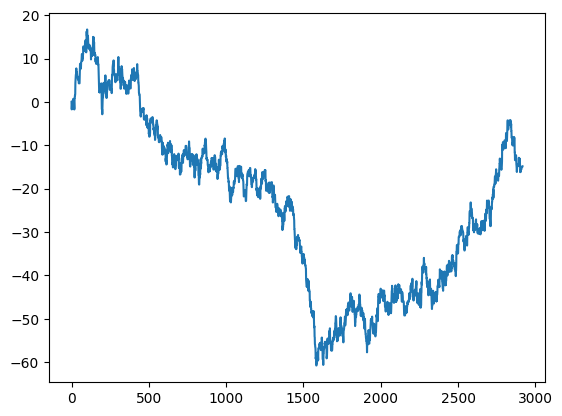

In [65]:
plt.plot(np.cumsum(rewards))

In [66]:
next_state

,feat1,feat2
2023-01-01,1.059871,-0.143854


## seq_len=3, 開始/終了指定なし

In [67]:
env = MarketEnv(
    action_space=ActionSpace(actions=ACTIONS),
    df_states_ts=df_states_ts,
    df_rewards_ts=df_rewards_ts,
    state_seq_len=3,
)

In [68]:
state = env.reset()

In [69]:
state

,feat1,feat2
2021-01-01 00:00:00,-0.082230,0.769312
2021-01-01 06:00:00,-2.410690,-0.199746
2021-01-01 12:00:00,0.628049,-1.389829


In [70]:
next_state, reward, is_done, info = env.step(0)

In [71]:
next_state

,feat1,feat2
2021-01-01 06:00:00,-2.410690,-0.199746
2021-01-01 12:00:00,0.628049,-1.389829
2021-01-01 18:00:00,1.777217,-0.594600


In [72]:
reward, is_done, info

(0.0, False, None)

In [73]:
next_state, reward, is_done, info = env.step(1)

In [74]:
next_state

,feat1,feat2
2021-01-01 12:00:00,0.628049,-1.389829
2021-01-01 18:00:00,1.777217,-0.594600
2021-01-02 00:00:00,-0.100970,-0.679747


In [75]:
reward, is_done, info

(0.1256725841269696, False, None)

In [77]:
df_rewards_ts.loc['2021-01-01 18:00:00'].iloc[1]

0.1256725841269696

In [78]:
next_state, reward, is_done, info = env.step(2)

In [79]:
next_state

,feat1,feat2
2021-01-01 18:00:00,1.777217,-0.594600
2021-01-02 00:00:00,-0.100970,-0.679747
2021-01-02 06:00:00,0.945688,-0.149249


In [80]:
reward, is_done, info

(1.720095024670484, False, None)

In [81]:
df_rewards_ts.loc['2021-01-02 00:00:00'].iloc[2]

1.720095024670484

In [82]:
rewards = []

while not is_done:
    action = np.random.randint(0, N_ACTIONS)
    next_state, reward, is_done, info = env.step(action)
    rewards.append(reward)

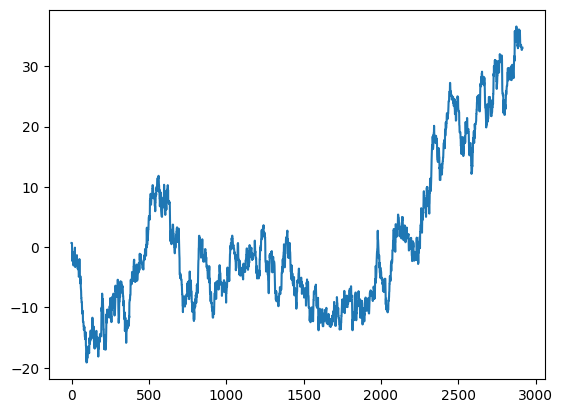

In [83]:
plt.plot(np.cumsum(rewards))

In [84]:
next_state

,feat1,feat2
2022-12-31 12:00:00,-0.738735,-0.038484
2022-12-31 18:00:00,-1.387207,0.985666
2023-01-01 00:00:00,1.059871,-0.143854


## seq_len=1, 開始/終了指定あり

In [91]:
df_states_ts.index[300], df_states_ts.index[-300]

(Timestamp('2021-03-17 00:00:00', freq='6H'),
 Timestamp('2022-10-18 06:00:00', freq='6H'))

In [88]:
env = MarketEnv(
    action_space=ActionSpace(actions=ACTIONS),
    df_states_ts=df_states_ts,
    df_rewards_ts=df_rewards_ts,
    state_seq_len=1,
    start_dt=df_states_ts.index[300],
    end_dt=df_states_ts.index[-300],
)

In [89]:
state = env.reset()

In [90]:
state

,feat1,feat2
2021-03-17,0.478226,-1.279598


In [92]:
next_state, reward, is_done, info = env.step(0)

In [93]:
next_state

,feat1,feat2
2021-03-17 06:00:00,0.406747,0.39072


In [94]:
reward, is_done, info

(0.0, False, None)

In [95]:
next_state, reward, is_done, info = env.step(1)

In [96]:
next_state

,feat1,feat2
2021-03-17 12:00:00,0.829515,-0.316418


In [97]:
reward, is_done, info

(-0.016154639802031148, False, None)

In [98]:
df_rewards_ts.loc['2021-03-17 06:00:00'].iloc[1]

-0.016154639802031148

In [99]:
next_state, reward, is_done, info = env.step(2)

In [100]:
next_state

,feat1,feat2
2021-03-17 18:00:00,0.415931,1.847542


In [101]:
reward, is_done, info

(-0.28457092779703047, False, None)

In [102]:
df_rewards_ts.loc['2021-03-17 12:00:00'].iloc[2]

-0.28457092779703047

In [103]:
rewards = []

while not is_done:
    action = np.random.randint(0, N_ACTIONS)
    next_state, reward, is_done, info = env.step(action)
    rewards.append(reward)

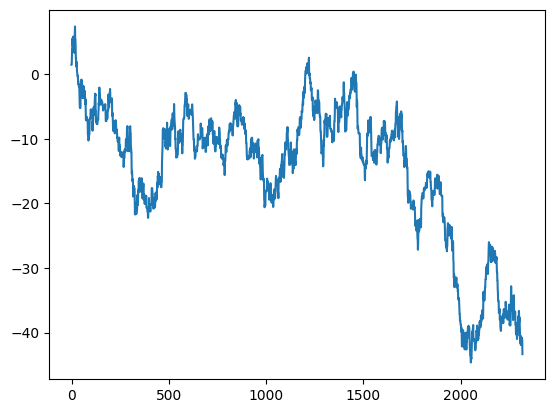

In [104]:
plt.plot(np.cumsum(rewards))

In [105]:
next_state

,feat1,feat2
2022-10-18 06:00:00,-0.187969,0.22798


In [107]:
next_state.to_numpy()

array([[-0.18796863,  0.22798002]])

In [108]:
next_state.to_numpy().shape

(1, 2)

In [109]:
np.squeeze(next_state.to_numpy()).shape

(2,)

## multi state, seq_len=1, 開始/終了指定なし

In [66]:
env = MarketEnvMultiState(
    action_space=ActionSpace(actions=ACTIONS),
    df_states_ts=df_states_multi_ts,
    df_rewards_ts=df_rewards_multi_ts,
    state_seq_len=1,
)

In [67]:
state, rewards = env.reset()

In [68]:
state

,feat1,feat2
2021-01-01,0.818085,0.643048


In [69]:
next_state, reward, is_done, info = env.step(0, state, rewards)

In [70]:
next_state

,feat1,feat2
2021-01-01 06:00:00,-0.061614,-0.346206


In [71]:
reward, is_done

(0.0, False)

In [72]:
info

{'df_next_rewards':                      do_nothing       buy      sell
 2021-01-01 06:00:00         0.0  0.110148 -0.110148}

In [73]:
next_state, reward, is_done, info = env.step(1, next_state, info['df_next_rewards'])

In [74]:
next_state

,feat1,feat2
2021-01-01 12:00:00,-0.581768,-1.328417


In [75]:
reward, is_done

(0.11014774072074454, False)

In [76]:
info

{'df_next_rewards':                      do_nothing       buy      sell
 2021-01-01 12:00:00         0.0  1.721141 -1.721141}

In [77]:
next_state, reward, is_done, info = env.step(2, next_state, info['df_next_rewards'])

In [78]:
next_state

,feat1,feat2
2021-01-01 18:00:00,-1.315339,-0.011659


In [79]:
reward, is_done

(-1.7211405818368708, False)

In [80]:
info

{'df_next_rewards':                      do_nothing       buy      sell
 2021-01-01 18:00:00         0.0 -1.072202  1.072202}

In [81]:
rewards = []

while not is_done:
    action = np.random.randint(0, N_ACTIONS)
    next_state, reward, is_done, info = env.step(action, next_state, info['df_next_rewards'])
    rewards.append(reward)

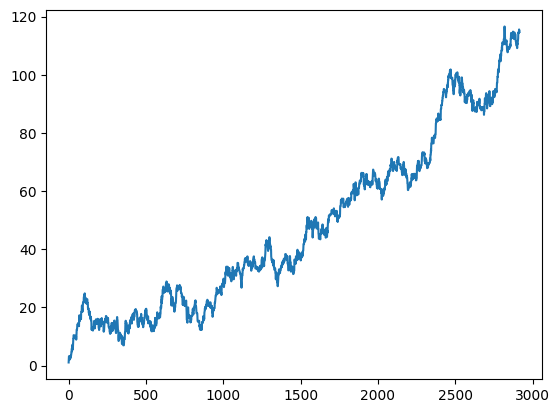

In [82]:
plt.plot(np.cumsum(rewards))

In [83]:
next_state

,feat1,feat2
2023-01-01,-0.133274,0.659765
